In [1]:
import anki_vector
import time
from PIL import Image
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

%matplotlib inline


#### Helper functions

In [3]:
def get_floor_mask(hsv_image)
    lower_thres = np.array([10,50,60])
    upper_thres = np.array([70,175,200])
    mask = cv2.inRange(hsv_image, lower_thres, upper_thres)
#     res = cv2.bitwise_and(frame,frame, mask= mask)
    return mask

#### Image points of square grid for Perspective transform

<IPython.core.display.Javascript object>


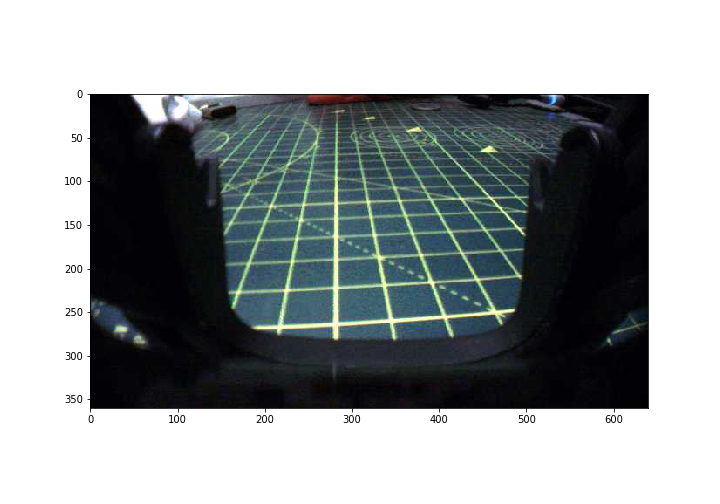

In [41]:
# %matplotlib notebook

# fig = plt.figure(figsize=(10,7))
# plt.imshow(frame)
# plt.show()
# %matplotlib inline

Coorinates of Lower left corner in counter clockwise direction:  
(285, 260)  
(342, 257)  
(335, 221)  
(285, 223) 

Coordinates of grid in world frame:  
(13, 10)  
(14, 10)  
(14, 11)  
(13, 11)  

In [15]:
## Perform perspective transform
def perspect_transform(img, src, dst):
    # Get transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp image
    # keep same size as input image
    warped = cv2.warpPerspective(img, M, (img.shape[1], img.shape[0]))
    return warped

def rover_coords(binary_img):
    # Identify nonzero pixels
    ypos, xpos = binary_img.nonzero()
    # Calculate pixel positions with reference to the rover position being at the 
    # center bottom of the image.  
    x_pixel = -(ypos - binary_img.shape[0]).astype(np.float)
    y_pixel = -(xpos - binary_img.shape[1]/2 ).astype(np.float)
    return x_pixel, y_pixel


### Continuous Mapping generation as the robot moves around.

Take the consecutive frames, estimate the robot translation and rotation and transform the corresponding map accordingly.

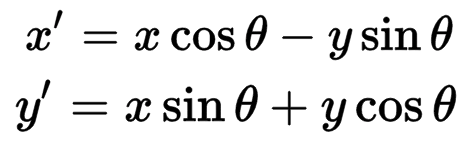

In [7]:

def rotate_pix(xpix, ypix, yaw_rad):
    # Convert yaw to radians
#     yaw_rad = yaw * np.pi / 180
    xpix_rotated = (xpix * np.cos(yaw_rad)) - (ypix * np.sin(yaw_rad))
    ypix_rotated = (xpix * np.sin(yaw_rad)) + (ypix * np.cos(yaw_rad))
    return xpix_rotated, ypix_rotated

def translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale): 
    # Apply a scaling and a translation
    xpix_translated = (xpix_rot / scale) + xpos
    ypix_translated = (ypix_rot / scale) + ypos
    return xpix_translated, ypix_translated

def pix_to_world(xpix, ypix, xpos, ypos, yaw, world_size, scale):
    # Apply rotation
    xpix_rot, ypix_rot = rotate_pix(xpix, ypix, yaw)
    # Apply translation
    xpix_tran, ypix_tran = translate_pix(xpix_rot, ypix_rot, xpos, ypos, scale)
    # Clip to world_size
    x_pix_world = np.clip(np.int_(xpix_tran), 0, world_size - 1)
    y_pix_world = np.clip(np.int_(ypix_tran), 0, world_size - 1)
    return x_pix_world, y_pix_world

#### Autonomous Navigation

Decide where to go by selecting the direction with least obstacles or in other words, the clearest path.
Convert pixel coordinates to polar coordinates and then calculate the average angles of all the pixels of the white mask

In [ ]:
def to_polar_coords(xpix, ypix):
    # Calculate distance to each pixel
    dist = np.sqrt(xpix**2 + ypix**2)
    # Calculate angle using arctangent function
    angles = np.arctan2(ypix, xpix)
    return dist, angles

In [ ]:
dst_size = 2
bottom_offset = 6

img_points = np.float32([[285, 260], [342, 257], [335, 221], [285, 223]])
# world_points = np.float32([[50, 5], [51, 5], [51, 6], [50, 6]])*5
world_points = np.float32([[frame.shape[1]/2 - dst_size, frame.shape[0] - bottom_offset],
                  [frame.shape[1]/2 + dst_size, frame.shape[0] - bottom_offset],
                  [frame.shape[1]/2 + dst_size, frame.shape[0] - 2*dst_size - bottom_offset], 
                  [frame.shape[1]/2 - dst_size, frame.shape[0] - 2*dst_size - bottom_offset],
                  ])

worldmap = np.zeros((600, 600))
scale = 5

#### Run the loop on Vector

In [ ]:
robot = anki_vector.AsyncRobot()
robot.connect()
robot.camera.init_camera_feed()
robot.motors.set_head_motor(-5.0) # move head to look at ground

time.sleep(2)
# robot.motors.set_wheel_motors(10, 10) # set initial driving direction

16:22:10.349               robot.Robot WARNING  No serial number or name provided. Automatically selecting 00603a88
16:22:10.356     connection.Connection    INFO  Connecting to 192.168.0.31:443 for Vector-E6N5 using /home/darsh/.anki_vector/Vector-E6N5-00603a88.cert
16:22:10.850     connection.Connection    INFO  BehaviorControl control_granted_response { }


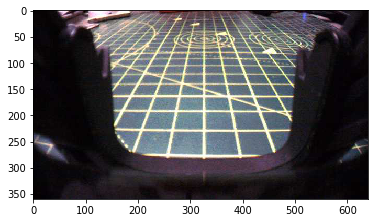

In [2]:
while(True):
    imageFromVector = robot.camera.latest_image
    frame = np.array(imageFromVector.raw_image)
    hsv_image = cv2.cvtColor(frame,cv2.COLOR_BGR2HSV) #convert image to gray
    mask = get_floor_mask(hsv_image)
    # plt.imshow(frame)
    # plt.show()
    warped_image = perspect_transform(mask, img_points, world_points)
    # plt.imshow(warped_image, cmap = 'gray')
    # plt.show()
    xpix, ypix = rover_coords(warped_image)
    # Plot the map in rover-centric coords
    # fig = plt.figure(figsize=(5, 7.5))
    # plt.plot(xpix, ypix, '.')
    # plt.ylim(-500, 500)
    # plt.xlim(0, 500)
    # plt.title('Vector-Centric Map', fontsize=20)
    # plt.show()
    current_robot_pose = robot.pose
    vector_xpos = current_robot_pose.position.x
    vector_ypos = current_robot_pose.position.y
    vector_yaw = current_robot_pose.rotation.angle_z.radians
    # Get navigable pixel positions in world coords
    x_world, y_world = pix_to_world(xpix, ypix, vector_xpos, 
                                    vector_ypos, vector_yaw, 
                                    worldmap.shape[0], scale)
    # Add pixel positions to worldmap
    worldmap[y_world, x_world] += 1
    print('Xpos =', vector_xpos, 'Ypos =', vector_ypos, 'Yaw =', vector_yaw)
    # Plot the map in vector-centric coords

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 7))
    f.tight_layout()
    ax1.plot(xpix, ypix, '.')
    ax1.set_title('vector Space', fontsize=40)
    ax1.set_ylim(-160, 160)
    ax1.set_xlim(0, 160)
    ax1.tick_params(labelsize=20)
    ax2.imshow(worldmap, cmap='gray')
    ax2.set_title('World Space', fontsize=40)
    ax2.set_ylim(0, 300)
    ax2.tick_params(labelsize=20)
    ax2.set_xlim(0, 300)
    plt.subplots_adjust(left=0.1, right=1, top=0.9, bottom=0.1)
    plt.show()

robot.disconnect()

In [6]:
import anki_vector
from anki_vector.util import degrees

# Create the robot connection
with anki_vector.AsyncRobot() as robot:
    # Start saying text asynchronously
    say_future = robot.behavior.say_text("Now is the time")
    # Turn robot, wait for completion
    turn_future = robot.behavior.turn_in_place(degrees(3*360))
    turn_future.result()
    # Play greet animation trigger, wait for completion
    greet_future = robot.anim.play_animation_trigger("GreetAfterLongTime")
    greet_future.result()
    # Make sure text has been spoken
    say_future.result()

18:10:25.417          robot.AsyncRobot WARNING  No serial number or name provided. Automatically selecting 00603a88
18:10:25.419     connection.Connection    INFO  Connecting to 192.168.0.31:443 for Vector-E6N5 using /home/darsh/.anki_vector/Vector-E6N5-00603a88.cert
18:10:26.026     connection.Connection    INFO  BehaviorControl control_granted_response { }


In [2]:
import asyncio
import time

import anki_vector

In [5]:
async def callback(robot, event_type, event):
    await asyncio.wrap_future(robot.anim.play_animation_trigger('GreetAfterLongTime'))
    await asyncio.wrap_future(robot.behavior.set_head_angle(anki_vector.util.degrees(40)))

if __name__ == "__main__":
#     args = anki_vector.util.parse_command_args()
    with anki_vector.AsyncRobot(enable_face_detection=True) as robot:
        robot.behavior.set_head_angle(anki_vector.util.degrees(40))
        robot.events.subscribe(callback, anki_vector.events.Events.robot_observed_face)

        # Waits 10 seconds. Show Vector your face.
        time.sleep(10)

17:49:20.940          robot.AsyncRobot WARNING  No serial number or name provided. Automatically selecting 00603a88
17:49:20.942     connection.Connection    INFO  Connecting to 192.168.0.31:443 for Vector-E6N5 using /home/darsh/.anki_vector/Vector-E6N5-00603a88.cert
17:49:21.650     connection.Connection    INFO  BehaviorControl control_granted_response { }


In [4]:
%tb

SystemExit: 2

In [9]:
robot.disconnect()